In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as T
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import random
from torcheval.metrics.classification.f1_score import MulticlassF1Score
import segmentation_models_pytorch as smp

In [2]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc = Accuracy('multiclass', num_classes=4, ignore_index=0).to(device)
    metric = MulticlassF1Score(average='macro', num_classes=4).to(device)
    with tqdm(train_loader, unit='batch') as tepochs:
        for img, mask in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            yp = model(img.to(device)) # b , 4, h, w  # mask, 
            yp = yp.view(yp.size(0), yp.size(1), -1)
            mask = mask.to(device).view(mask.size(0), -1)
            loss = loss_fn(yp, mask)
            metric.update(yp.argmax(1).view(-1), mask.view(-1))
            acc.update(yp, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tepochs.set_postfix(accuracy=acc.compute().item(), metric=metric.compute().item())
            loss_train.update(loss.item())
    return model, loss_train.avg, acc.compute().item()

def evaluate(model, test_loader, loss_fn):
    model.eval()
    acc = Accuracy('multiclass', num_classes=4, ignore_index=0).to(device)
    metric = MulticlassF1Score(average='macro', num_classes=4).to(device)

    loss_test = AverageMeter()
    with torch.no_grad():
        for img, mask in test_loader:
            yp = model(img.to(device))
            yp = yp.view(yp.size(0), yp.size(1), -1)
            mask = mask.to(device).view(mask.size(0), -1)
            metric.update(yp.argmax(1).view(-1), mask.view(-1))
            loss = loss_fn(yp, mask)
            loss_test.update(loss.item())
            acc.update(yp, mask)
    print(metric.compute().item())
    print(loss_test.avg)
    print(acc.compute().item())
    return loss_test.avg, acc.compute().item()

def inference(how_many):
    for i in range(how_many):
        imgs, mask = next(iter(test_loader))
        r = random.randint(0, 9)

        with torch.no_grad():
            preds = model(imgs[r].unsqueeze(0).to(device))
        fig, axes = plt.subplots(1, 2, figsize=(7, 7))
        axes[0].imshow(mask[r].squeeze())
        axes[0].set_title('real mask')
        axes[1].imshow(preds.squeeze().softmax(0).argmax(0).cpu())
        axes[1].set_title('predicted mask')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
df = pd.read_csv('data.csv')

In [5]:
def decode(coded, imshape):
    shape = imshape[0] * imshape[1]
    mask = np.asarray(coded.split(), dtype=int)
    st = mask[::2]
    le = mask[1::2]
    ends = st + le  
    imas = np.zeros(shape, dtype=int)
    for low, high in zip(st, ends):
        imas[low:high] = 1
    return imas.reshape(imshape)

In [6]:
with open('train.txt') as f :
    train = f.read().splitlines()
with open('test.txt') as f :
    test = f.read().splitlines()

In [7]:
def get_segmented_with_same_format(df):
    get_vals_train = list()
    get_vals_test = list()
    for i in range(0, len(df), 3):
        bakt = df.iloc[i:i+3].dropna().values
        if bakt.shape[0] != 0:
            if bakt[0][0] in train:
                get_vals_train.append(bakt)
            else:
                get_vals_test.append(bakt)
    return get_vals_train, get_vals_test

In [8]:
train_data, test_data = get_segmented_with_same_format(df)

In [9]:
train_transforms = T.Compose([
            T.Resize((256, 256)), T.Normalize(0.5, 0.5)
])
mask_transform = T.Resize((256, 256))

In [10]:
class MySegDataset(Dataset):
    
    def __init__(self, datas: list):
        classes = {'large_bowel': 1, 'stomach': 2, 'small_bowel' : 3}
        self.datas = datas
        tr = T.ToTensor()
        self.y = list()
        self.x = list()
        for sample in self.datas:
            ims = tr(Image.open(sample[0][-1]))
            decoded_image = torch.zeros((ims.shape[1:]), dtype=torch.long)
             # creating image with labels on each pixel shape 1xhxw background is zero
            for i in sample:
                temp_dec = decode(i[6], ims.shape[1:])
                decoded_image[temp_dec == 1] = classes[i[3]]
            self.y.append(mask_transform(decoded_image.unsqueeze(0))) 
            self.x.append(train_transforms(ims / 255))  # main Image
    def __getitem__(self, idx):
        return self.x[idx],  self.y[idx]
    
    def __len__(self):
        return len(self.x)
    

In [11]:
train_set = MySegDataset(train_data)
test_set = MySegDataset(test_data)

/home/vahid/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
train_loader = DataLoader(train_set, batch_size=30, shuffle=True)
test_loader = DataLoader(test_set, batch_size=30, shuffle=True)

In [14]:
model = smp.Unet(encoder_name='resnet50', in_channels=1, classes=4).to(device)

In [15]:
sum(p.numel() for p in model.parameters())

32515268

In [16]:
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [17]:
loss_train_hist = list()
loss_valid_hist = list()
acc_train_hist = list()
acc_valid_hist = list()
epoch_counter = 0
best_loss = 1e+4

In [18]:
n = 100
for epoch in range(n):
    model, train_loss, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss, acc_test = evaluate(model, test_loader, loss_fn)
    
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)
    acc_train_hist.append(acc_train_hist)
    acc_valid_hist.append(acc_valid_hist)

    if best_loss > valid_loss:
        torch.save(model,'modelx1.pt')
        best_loss =  valid_loss
        print('Model SAVED') 

    epoch_counter +=1

epoch:0: 100%|█| 401/401 [01:17<00:00,  5.14batch/s, accuracy=0.319, metric=0.48


0.6460886001586914
0.08600942123877375
0.4724937677383423
Model SAVED


epoch:1: 100%|█| 401/401 [01:18<00:00,  5.10batch/s, accuracy=0.731, metric=0.81


0.7487751245498657
0.061142213250461375
0.5958105325698853
Model SAVED


epoch:2: 100%|█| 401/401 [01:19<00:00,  5.06batch/s, accuracy=0.756, metric=0.83


0.794830322265625
0.04893947757878586
0.7043364644050598
Model SAVED


epoch:3: 100%|█| 401/401 [01:17<00:00,  5.16batch/s, accuracy=0.767, metric=0.84


0.770337700843811
0.05384403337283354
0.6813673377037048


epoch:4: 100%|█| 401/401 [01:18<00:00,  5.11batch/s, accuracy=0.773, metric=0.84


0.7758892774581909
0.05355694434164386
0.6539981961250305


epoch:5: 100%|█| 401/401 [01:18<00:00,  5.12batch/s, accuracy=0.779, metric=0.85


0.7046027183532715
0.08588665194417301
0.5222066044807434


epoch:6: 100%|█| 401/401 [01:18<00:00,  5.13batch/s, accuracy=0.783, metric=0.85


0.7764484882354736
0.05939295221316187
0.6154351234436035


epoch:7: 100%|█| 401/401 [01:17<00:00,  5.19batch/s, accuracy=0.789, metric=0.85


0.7156480550765991
0.08173097885752979
0.5671159625053406


epoch:8: 100%|███████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:18<00:00,  5.11batch/s, accuracy=0.79, metric=0.859]


0.7220267653465271
0.09834671900362561
0.5886583924293518


epoch:9: 100%|██████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:19<00:00,  5.05batch/s, accuracy=0.793, metric=0.861]


0.7818499803543091
0.05409945692180803
0.7092227935791016


epoch:10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:18<00:00,  5.09batch/s, accuracy=0.795, metric=0.863]


0.7217943668365479
0.11235593207866738
0.5417827367782593


epoch:11: 100%|███████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:22<00:00,  4.87batch/s, accuracy=0.8, metric=0.866]


0.7511917352676392
0.07896322676127679
0.578391432762146


epoch:12: 100%|█████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:17<00:00,  5.15batch/s, accuracy=0.803, metric=0.869]


0.7792822122573853
0.062366529024745286
0.6720768809318542


epoch:13: 100%|██████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:17<00:00,  5.15batch/s, accuracy=0.804, metric=0.87]


0.6997660994529724
0.1272582933306694
0.5271769762039185


epoch:14: 100%|██████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:18<00:00,  5.10batch/s, accuracy=0.805, metric=0.87]


0.7730796337127686
0.05781225355243996
0.6375570893287659


epoch:15: 100%|█████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:19<00:00,  5.07batch/s, accuracy=0.806, metric=0.871]


0.738823652267456
0.0878910928670513
0.5620855689048767


epoch:16: 100%|█████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:16<00:00,  5.22batch/s, accuracy=0.807, metric=0.872]


0.7786511778831482
0.05918598312296366
0.6579241752624512


epoch:17:  78%|██████████████████████████████████████████████████████████████████████████████████▏                       | 311/401 [01:01<00:17,  5.09batch/s, accuracy=0.813, metric=0.875]


KeyboardInterrupt: 

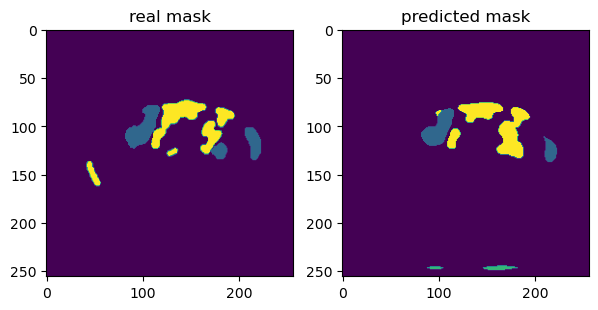

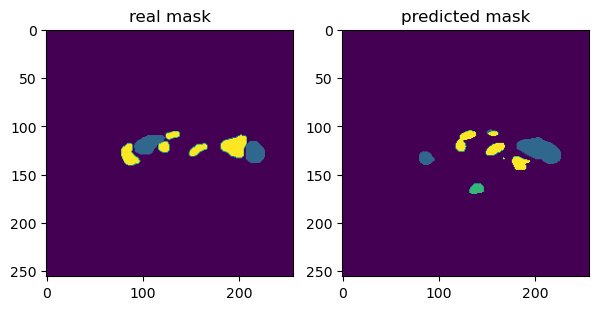

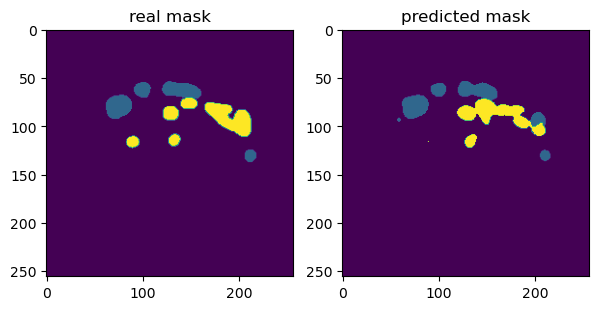

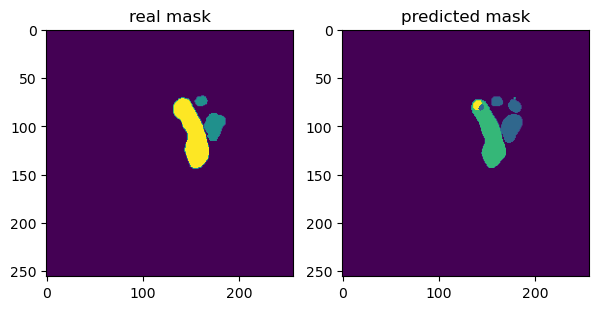

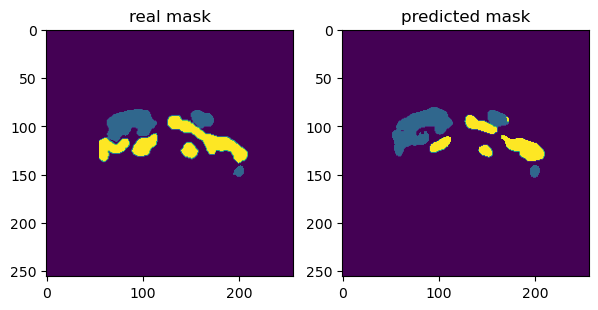

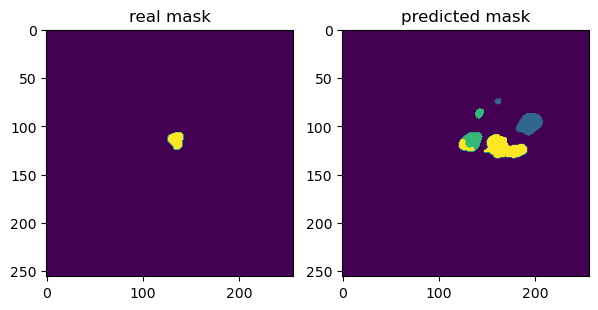

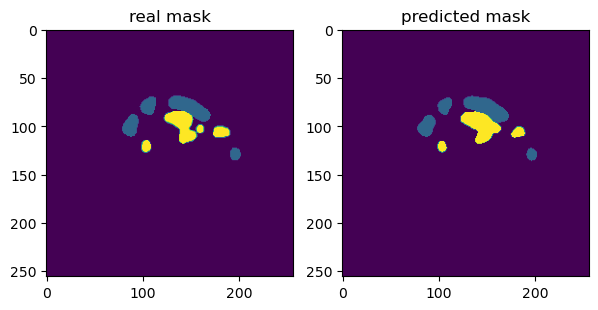

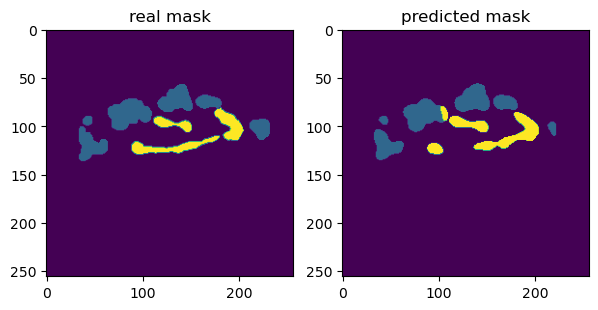

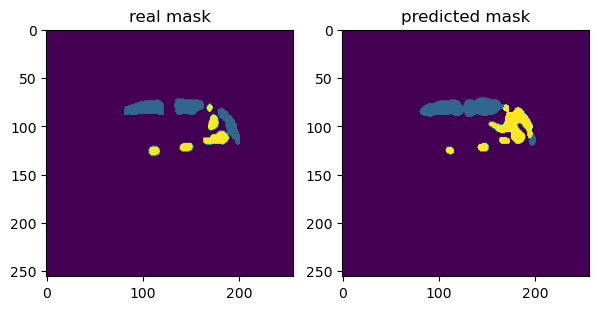

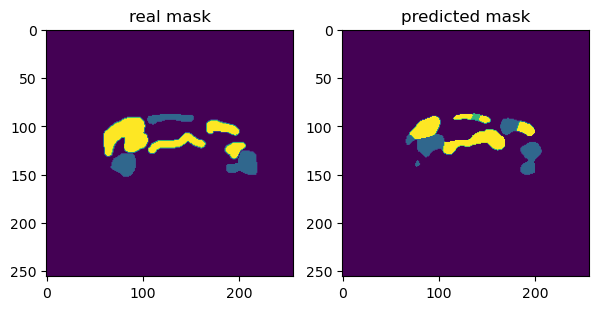

In [19]:
inference(10)